# Bank Marketing with Machine Learning
### Introduction
### Using Machine Learning to Predict Subscription to Bank Term Deposits for Clients with Scikit-Learn

This project aims to apply machine learning algorithms to solve a classification problem in data science. Specifically, we will use a dataset related to direct marketing campaigns of a Portuguese banking institution to predict whether a client will subscribe or not to a term deposit. The dataset contains information on client demographics, previous marketing interactions, and economic indicators.

We will explore various machine learning algorithms, including logistic regression, decision trees, and random forests, to build models and evaluate their performance using appropriate metrics. Through this project, we hope to gain practical experience in data science while addressing a real-world problem.


### Dataset

#### bank client data:
1. age (numeric)
2. job : type of job (categorical: ‘admin.’,’blue-collar’,’entrepreneur’,’housemaid’,’management’,’retired’,’self-employed’,’services’,’student’,’technician’,’unemployed’,’unknown’)
3. marital : marital status (categorical: ‘divorced’,’married’,’single’; note: ‘divorced’ means divorced or widowed)
4. education (categorical: 'primary', 'secondary', 'tertiary', 'unknown')
5. default: has credit in default? (categorical: ‘no’,’yes’)
6. balance: account balance of the client (numeric)
7. housing: has housing loan? (categorical: ‘no’,’yes’)
8. loan: has personal loan? (categorical: ‘no’,’yes’)

#### related with the last contact of the current campaign:
9. contact: contact communication type (categorical: ‘cellular’, ’telephone’, 'unknown')
10. day: last contact day of the month (numeric).
11. month: last contact month of year (categorical: ‘jan’, ‘feb’, ‘mar’, …, ‘nov’, ‘dec’)
12. duration: last contact duration, in seconds (numeric). Important note: the duration attribute has a significant impact on the output target. As the duration is only known after the call has ended, it is advisable to include this input only for benchmarking purposes. In realistic predictive modelling, this feature should be discarded.

#### other attributes:
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: ‘failure’, ’success’, 'other', 'unknown')

#### Output variable (desired target):

17. deposit: has the client subscribed a term deposit? (binary: ‘yes’,’no’)

#### Project will be divided in the following steps:
-data exploration
-feature engineering
-building training/validation/test samples
-model selection
-model evaluation

#### Project Definition
The classification goal is to predict if a client will subscribe to the bank term deposit (yes/no).

# Import Base Libraries

In [1]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

# Logging

This code defines a custom logger class that allows me to print messages in a visually appealing and easily distinguishable way in the console output. It provides different log levels, each with its corresponding color and formatting, to enhance the readability of the printed messages.

By using this code, I can improve the aesthetic quality of console output messages and make it easier for me to identify the severity of the logged events.

In [2]:
from enum import Enum

def bold(text):
    return "\033[1m" + text + "\033[0m"

class LogLevel(Enum):
    ERROR = "\033[91m🔴 ERROR\033[0m"
    WARNING = "\033[93m⚠️ WARNING\033[0m"
    INFO = "\033[94m🟡 INFO\033[0m"
    DEBUG = "\033[34m🔵 DEBUG\033[0m"
    SUCCESS = "\033[32m🟢 SUCCESS\033[0m"


class Logger:
    def __init__(self, level=LogLevel.INFO):
        self.level = level

    def log(self, level, message, **kwargs):
        if level.value <= self.level.value:
            nl = kwargs.get('nl', False)
            if nl:
                print()
            print(f"{level.value}: {message}")

    def error(self, message, **kwargs):
        self.log(LogLevel.ERROR, message, **kwargs)

    def warning(self, message, **kwargs):
        self.log(LogLevel.WARNING, message, **kwargs)

    def info(self, message, **kwargs):
        self.log(LogLevel.INFO, message, **kwargs)

    def debug(self, message, **kwargs):
        self.log(LogLevel.DEBUG, message, **kwargs)

    def success(self, message, **kwargs):
        self.log(LogLevel.SUCCESS, message, **kwargs)
        
logger = Logger(level=LogLevel.INFO)

# Preprocessing Presets

The provided code defines several functions and classes to perform common data preprocessing tasks. Specifically, it includes functions to split data into input features and targets, encode categorical variables using label, one-hot, or ordinal encoding, scale features using standardization, and perform a series of data cleaning steps on a particular dataset.

I will use this code as a toolset to prepare and clean data for various machine learning tasks.

In [3]:
# import relevant libraries
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler

# preprocessing methods
def split_data(data, target_col=None):
    data = data.dropna()
    if target_col is None:
        X = data.iloc[:, :-1]
        y = data.iloc[:, -1]
    else:
        X = data.drop(target_col, axis=1)
        y = data[target_col]
    return X, y


def label_encode(target, mode='sklearn'):
    if mode == 'sklearn':
        return LabelEncoder().fit_transform(target)


def one_hot_encode(X, mode='pandas', **kwargs):
    if mode == 'pandas':
        return pd.get_dummies(X, **kwargs)
    if mode == 'sklearn':
        return OneHotEncoder().fit_transform(X, **kwargs)


def ordinal_encode(X, mode='sklearn', **kwargs):
    if mode == 'sklearn':
        return OrdinalEncoder().fit_transform(X, **kwargs)


def standard_scale(X, mode='sklearn', **kwargs):
    if mode == 'sklearn':
        return StandardScaler().fit_transform(X, **kwargs)


def full_clean(df):
    df['is_default'] = df['default'].apply(lambda row: 1 if row == 'yes' else 0)
    df['is_housing'] = df['housing'].apply(lambda row: 1 if row == 'yes' else 0)
    df['is_loan'] = df['loan'].apply(lambda row: 1 if row == 'yes' else 0)
    df['target'] = df['deposit'].apply(lambda row: 1 if row == 'yes' else 0)

    marital_dummies = pd.get_dummies(df['marital'], prefix='marital')
    marital_dummies.drop('marital_divorced', axis=1, inplace=True)
    df = pd.concat([df, marital_dummies], axis=1)

    job_dummies = pd.get_dummies(df['job'], prefix='job')
    job_dummies.drop('job_unknown', axis=1, inplace=True)
    df = pd.concat([df, job_dummies], axis=1)

    education_dummies = pd.get_dummies(df['education'], prefix='education')
    education_dummies.drop('education_unknown', axis=1, inplace=True)
    df = pd.concat([df, education_dummies], axis=1)

    contact_dummies = pd.get_dummies(df['contact'], prefix='contact')
    contact_dummies.drop('contact_unknown', axis=1, inplace=True)
    df = pd.concat([df, contact_dummies], axis=1)

    poutcome_dummies = pd.get_dummies(df['poutcome'], prefix='poutcome')
    poutcome_dummies.drop('poutcome_unknown', axis=1, inplace=True)
    df = pd.concat([df, poutcome_dummies], axis=1)

    months = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10,
              'nov': 11, 'dec': 12}
    df['month'] = df['month'].map(months)

    df.drop(['job', 'education', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome', 'deposit'],
            axis=1, inplace=True)

    return df

# Read Data for Data Exploration

This code performs data preprocessing for a machine learning model by importing necessary libraries, loading and splitting the dataset into features and target variables, encoding categorical features, and splitting the data into training and testing sets. The purpose of this preprocessing is to prepare the data for modeling and improve the accuracy of the resulting machine learning model.

In [4]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('bank.csv')

print('%s: %s\n' % (bold('Number of samples'), len(data)))

print(bold('Dataset info'))
print(data.info(), '\n')

print(bold('Dataset preview'))
print(data.head(), '\n')

# split the data
X, y = split_data(data)

# get the feature labels
features = X.columns

# use simple ordinal and label encode so we can maintain dataset structure
X = ordinal_encode(X)
y = label_encode(y)

# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60)

# get numeric and categorical columns
numeric_col = data.select_dtypes(include=['int64', 'float64']).columns
category_col = data.select_dtypes(include=['object']).columns

print('%s: %s\n' % (bold('Numeric columns'), numeric_col.values))
print('%s: %s\n' % (bold('Categorical columns'), category_col.values))

print(bold('Dataset granularity'))
for col in data.columns:
    print(col, ':', data[col].nunique(), 'unique values')

Number of samples: 11162

Dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB
None 

Dataset preview
   age         job  marital  educatio

# Data Exploration

### Prevalence of Target Class
This pie chart represents the distribution of the deposit column in the dataset. The yes and no labels show whether the customer has made a deposit or not, respectively. The chart shows that the dataset is relatively balanced, with no representing 52.6% of the data and yes representing 47.4%.

If it was inbalanced we would need to adjust our data to prevent anomalies during training.

<IPython.core.display.Javascript object>


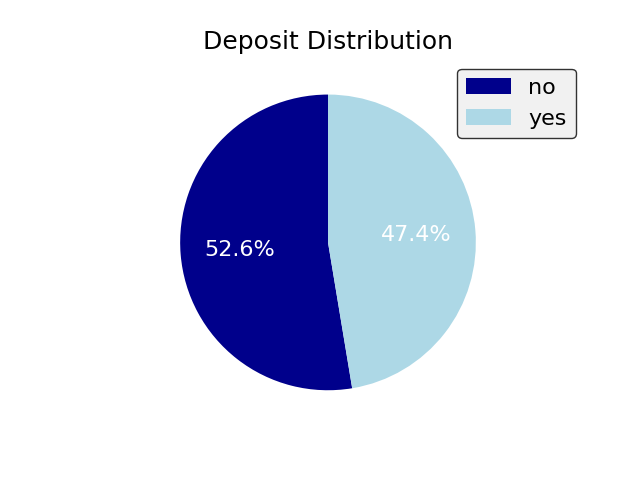

Deposit class values
deposit
no     5873
yes    5289
dtype: int64 

Prevalence of the positive class: 0.474



In [5]:
def calc_prevalence(y_actual):
    # this function calculates the prevalence of the positive class (label = 1)
    return sum(y_actual) / len(y_actual)

plt.figure()

# Define the colors for 'no' and 'yes' 
colors = ["#00008b", "#ADD8E6"]

# Create the pizza plot
plt.pie(data['deposit'].value_counts(), 
        labels=['no', 'yes'], 
        colors=colors, 
        autopct='%1.1f%%', 
        startangle=90, 
        textprops={'color': 'w', 'fontsize': 16})

# Add a title to the plot
plt.title('Deposit Distribution', fontsize=18)

# Add a legend to the plot with white 'no' label
plt.legend(labels=['no', 'yes'], bbox_to_anchor=(1.2, 1), loc='upper right', prop={'size': 16}, facecolor='#EEE', edgecolor='#000000')

# Show the plot
plt.show()

# count the number of rows for each type
print(bold('Deposit class values'))
print(data.groupby('deposit').size(), '\n')

print('%s: %.3f\n' % (bold('Prevalence of the positive class'), calc_prevalence(y)))

### Point-Biserial correlation for each feature with target variable

The code computes the point-biserial correlation between each feature in a dataset and a desired target variable. The resulting correlation coefficients are plotted as a bar chart. The x-axis shows the feature names, and the y-axis shows the correlation coefficients. The resulting plot allows us to visualize the strength and direction of the relationship between each feature and the target variable.

The figure pratically gives us an indication on how important a feature might be. As mentioned in the introduction, the duration feature has a significant impact in the final result.

<IPython.core.display.Javascript object>


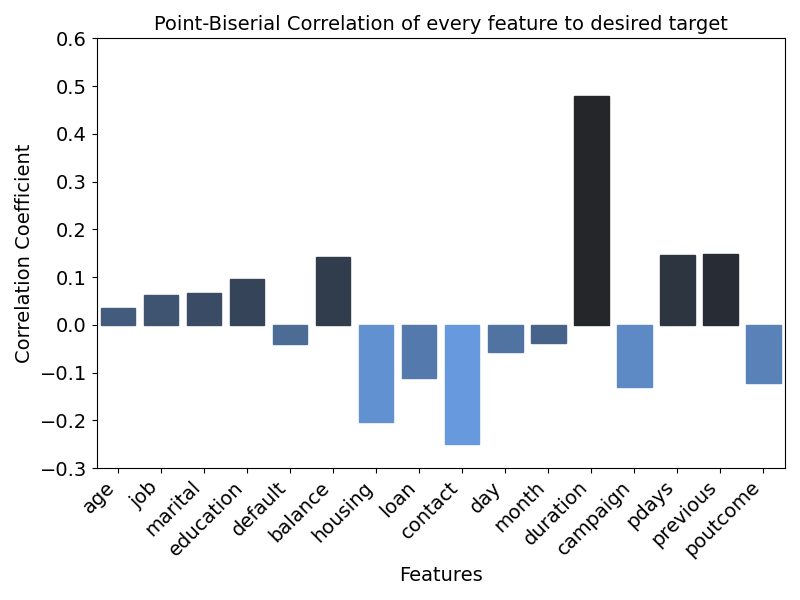

In [6]:
from scipy.stats import pointbiserialr

# Calculate Point-Biserial correlation for each feature with target variable
correlations = []
for i in range(X.shape[1]):
    corr, pval = pointbiserialr(X[:,i], y)
    correlations.append(corr)

# Define color palette and map correlations to colors
cmap = sns.dark_palette('#69d', n_colors=len(features), reverse=True)
cor_range = max(correlations) - min(correlations)
color_mapping = dict(zip(sorted(correlations), cmap))  # map correlations to colors

# Set up visualization using seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=features, y=correlations, palette=cmap)

# Color each bar based on its correlation value
for i, corr in enumerate(correlations):
    color = color_mapping[corr]
    ax.get_children()[i].set_color(color)

# Add title and axis labels, adjust font size, and rotate x-axis labels
plt.title('Point-Biserial Correlation of every feature to desired target', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
yticklabels = ax.get_yticklabels()
yticks = ax.get_yticks()
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=14)
plt.subplots_adjust(bottom=.2)

# show the plot
plt.tight_layout()
plt.show()

### Numerical columns

#### Correlation heatmap

The heatmap shows the correlation between the numeric features of the dataset. The cells colored in blue represent high positive correlation while the cells colored in white represent low correlation. The values in each cell represent the correlation coefficient between the corresponding features. This plot can be useful in identifying which features are strongly correlated and can be used in combination in a machine learning model.

<IPython.core.display.Javascript object>


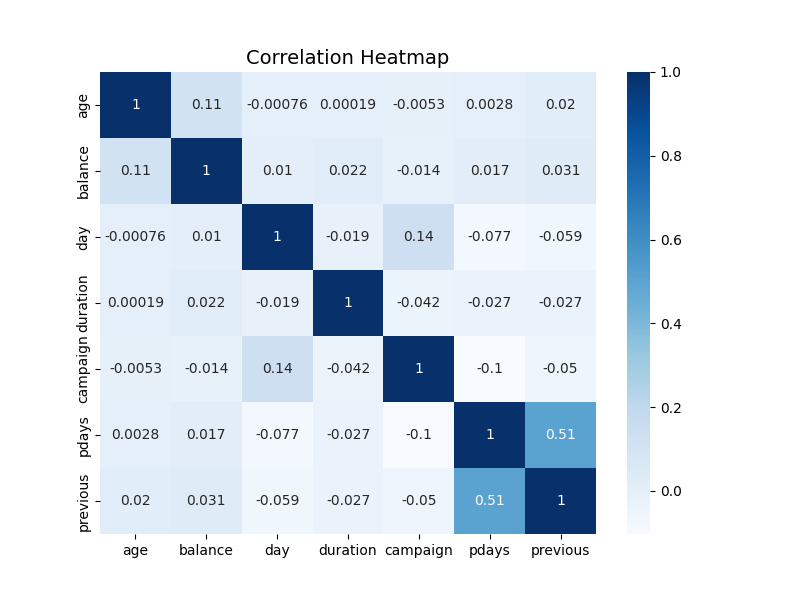

In [7]:
# Create the heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(data[numeric_col].corr(), cmap='Blues', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 14})
plt.show()

#### Pair gird

This plot is a PairGrid visualization that shows the relationship between different numeric variables in the dataset, with each point on the scatterplot representing a single observation. The scatterplot points are colored by the deposit column, with the blue color representing 'no' and light blue representing 'yes'. This plot helps to identify any potential patterns or relationships between variables in the dataset and how they relate to the deposit column.

<IPython.core.display.Javascript object>


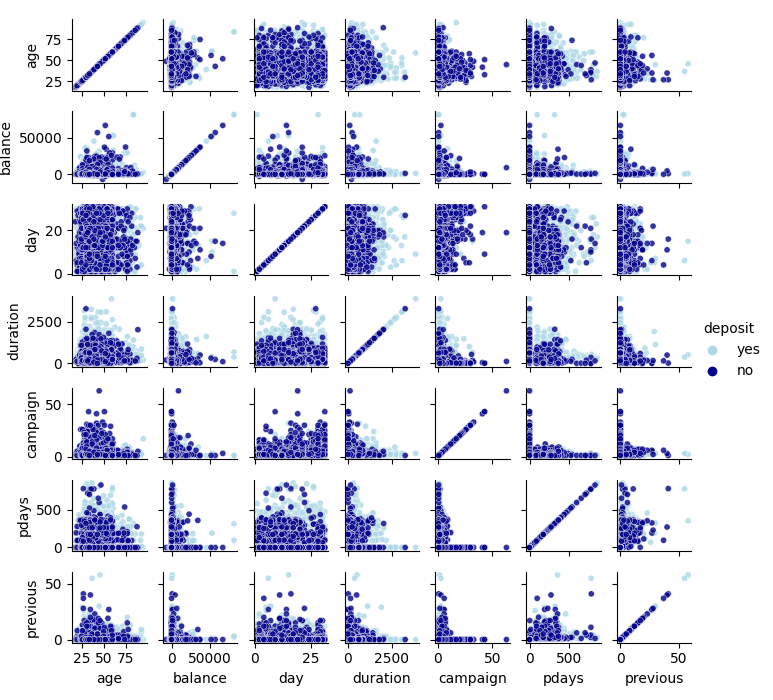

In [8]:
# Visualize distribution of dataset information
my_palette = {'yes': "#ADD8E6", 'no': "#00008b"}
g = sns.PairGrid(data, vars=numeric_col, hue='deposit', height=1, aspect=1, palette=my_palette) # PairGrid already creates figure
g.map(sns.scatterplot, s=20, alpha=.8)
g.add_legend()
plt.show()

#### Histograms

This code generates a grid of histograms, one for each numerical feature in the dataset. The histograms are grouped by the deposit status, with 'yes' and 'no' colored in blue and dark blue, respectively. Each histogram shows the distribution of the feature's values, with the x-axis representing the range of values and the y-axis representing the frequency or count of observations falling in that range. Overall, this plot provides a quick and visual way to compare the distribution of each numerical feature across the two deposit groups.

<IPython.core.display.Javascript object>


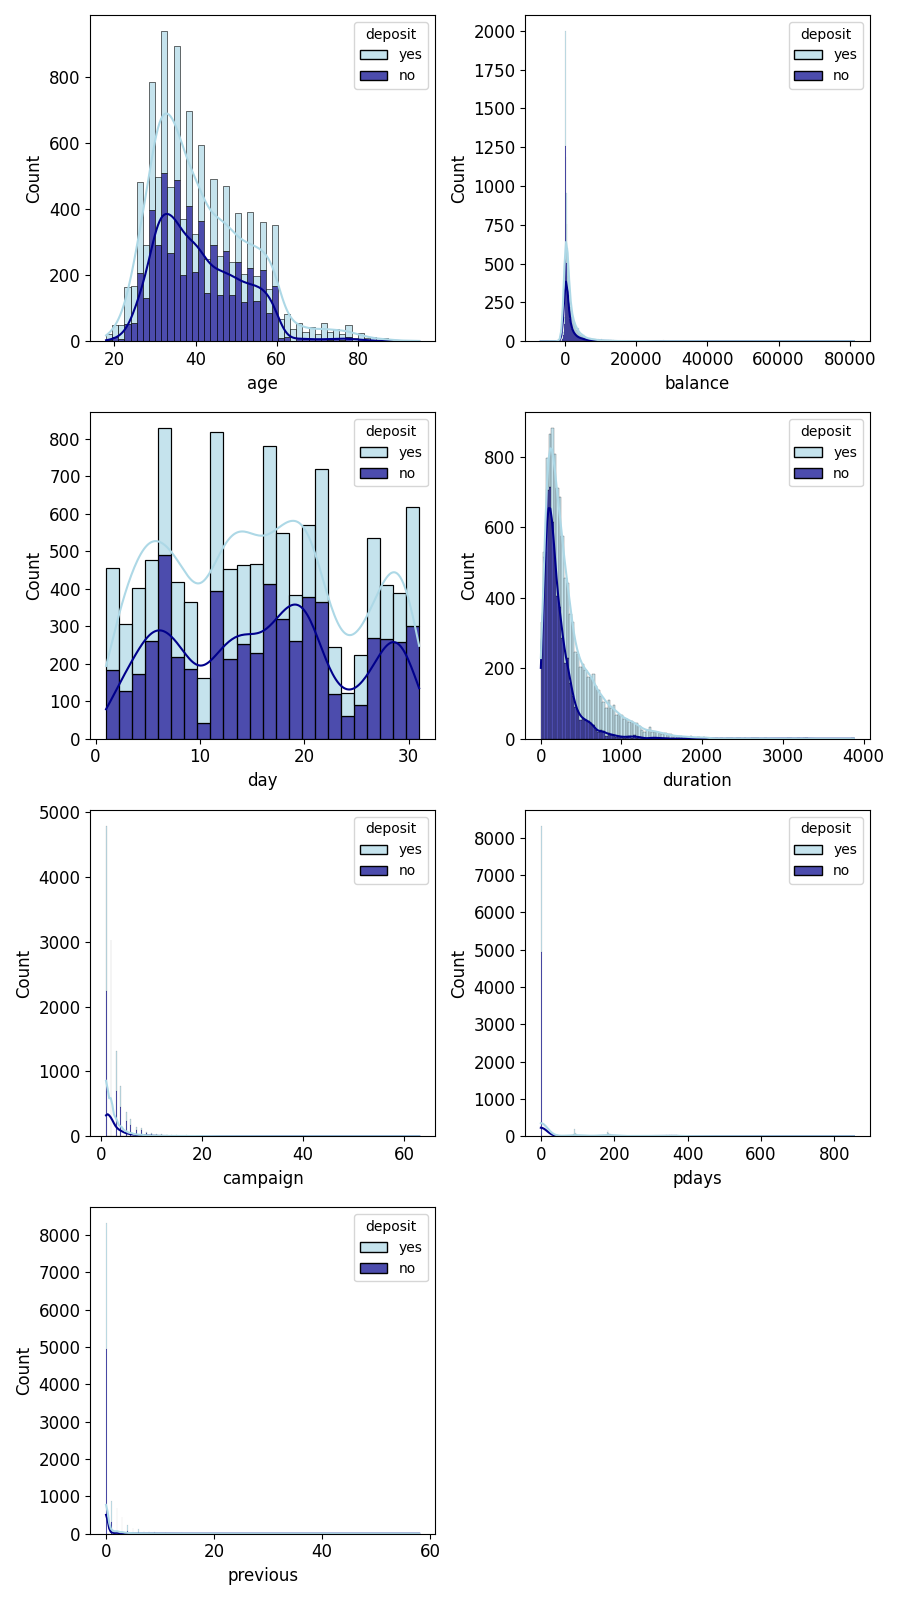

In [9]:
# Plot for each numerical feature

# Calculate the number of rows and columns needed to fit all the plots
n_cols = 2
n_rows = (len(numeric_col) + 1) // 2  # Round up if necessary
my_palette = {'yes': "#ADD8E6", 'no': "#00008b"}

# Create a subplot grid with the specified number of rows and columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 4*n_rows))

# Flatten the axes array to iterate over the subplots
axes = axes.flatten()

# Iterate over the continuous columns and create a histogram for each one
for i, col in enumerate(numeric_col):
    sns.histplot(data=data, x=col, hue='deposit', kde=True, multiple='stack', alpha=0.7, palette=my_palette, ax=axes[i])
    #axes[i].set_title(col)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    xticks, xticklabels = plt.xticks()
    plt.xticks(xticks, xticklabels, fontsize=12)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Show the plots
plt.tight_layout()
plt.show()

### Categorical columns

#### Countplot

This code generates a grid of subplots, with each subplot containing a countplot of a categorical column from a dataset. The 'deposit' column is used to color-code the bars in each countplot. The resulting plot provides an overview of the distribution of each categorical column and how it relates to the 'deposit' column.

<IPython.core.display.Javascript object>


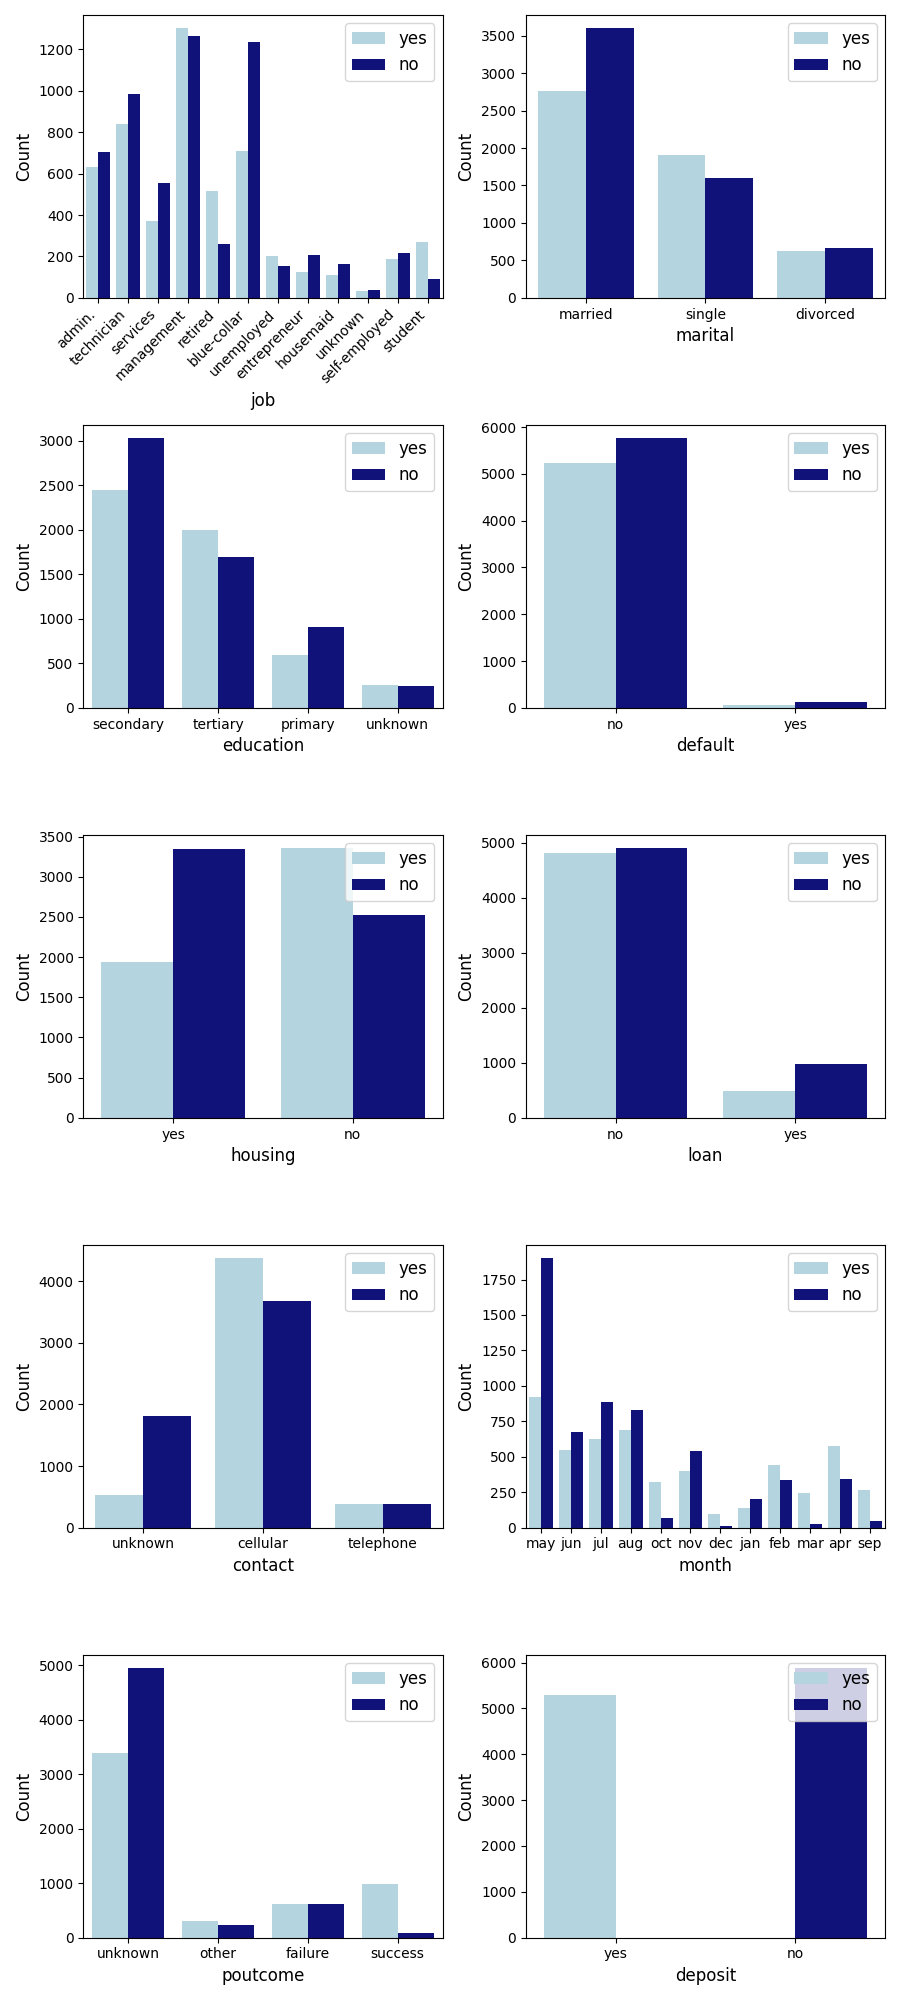

In [10]:
# Create a subplot grid with the specified number of rows and columns
n_cols = 2
n_rows = (len(category_col) + 1) // n_cols  # Round up if necessary
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 4*n_rows))

# Flatten the axes array to iterate over the subplots
axes = axes.flatten()

# Iterate over the categorical columns and create a count plot for each one
for i, col in enumerate(category_col):
    sns.countplot(data=data, x=col, hue='deposit', palette={'yes': "#ADD8E6", 'no': "#00008b"}, ax=axes[i])
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    axes[i].legend(loc='upper right', fontsize=12)
    
    # Set custom rotation and alignment for 'job' category labels
    if col == 'job':
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Show the plots
plt.tight_layout()
plt.show()

# Analytics Presets

In [11]:
# import relevant libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.tree import plot_tree

# analytics methods
def get_best(accuracy_map, out=True):
    sorted_accuracy_map = sorted(accuracy_map.items(), key=lambda x: x[1], reverse=True)
    if out:
        for i, (k, v) in enumerate(sorted_accuracy_map, start=1):
            print(f"{i}. {k} ({v})")
        print()
    return sorted_accuracy_map

def get_report(y_test, y_pred, out=True):
    accuracy_score_ = accuracy_score(y_test, y_pred)
    auc_roc_score_ = roc_auc_score(y_test, y_pred)
    confusion_matrix_ = confusion_matrix(y_test, y_pred)
    classification_report_ = classification_report(y_test, y_pred)
    if out:
        print("Accuracy score:", accuracy_score_)
        print("AUC-ROC score:", auc_roc_score_)
        print("Confusion matrix:\n", confusion_matrix_)
        print("Classification report:\n", classification_report_)
        print()
    return accuracy_score_, auc_roc_score_, confusion_matrix_, classification_report_


def plot_confusion_matrix(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_mat, annot=True, cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

def plot_roc(model, X_test, y_test):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Add a dashed diagonal line for comparison
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_decision_tree(clf, column_values):
    plt.figure(figsize=(20, 12), dpi=100)
    plot_tree(clf, feature_names=column_values, class_names=["no", "yes"], filled=True, fontsize=10, max_depth=3)
    plt.show()

def plot_feature_importance(model, features):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=model.feature_importances_, y=features, ax=ax, orient='h')
    ax.set_title('Feature Importance')
    plt.tight_layout()
    plt.show()


# Train Adapter

In [12]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, \
    ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


def train(X_train, y_train, name='logistic_regression', **kwargs):
    methods = {
        'logistic_regression': _logistic_regression,
        'decision_tree': _decision_tree,
        'gradient_boosting_machines': _gradient_boosting_machines,
        'naive_bayes': _naive_bayes,
        'random_forest': _random_forest,
        'support_vector_machines': _support_vector_machines,
        'k_nearest_neighbours': _k_nearest_neighbours,
        'adaboost': _adaboost,
        'xgboost': _xgboost,
        'multi_layer_perceptron': _multi_layer_perceptron,
        'ridge_classifier': _ridge_classifier,
        'passive_aggressive_classifier': _passive_aggressive_classifier,
        'extremely_randomized_trees': _extremely_randomized_trees,
        'lightgbm_classifier': _lightgbm_classifier
    }
    return methods[name](X_train, y_train, **kwargs)


def _logistic_regression(X_train, y_train, **kwargs):
    lr = LogisticRegression(**kwargs)
    lr.fit(X_train, y_train)
    return lr


def _decision_tree(X_train, y_train, **kwargs):
    clf = DecisionTreeClassifier(**kwargs)
    clf.fit(X_train, y_train)
    return clf


def _gradient_boosting_machines(X_train, y_train, **kwargs):
    gbm = GradientBoostingClassifier(**kwargs)
    gbm.fit(X_train, y_train)
    return gbm


def _naive_bayes(X_train, y_train, **kwargs):
    nb = GaussianNB(**kwargs)
    nb.fit(X_train, y_train)
    return nb


def _random_forest(X_train, y_train, **kwargs):
    rfc = RandomForestClassifier(**kwargs)
    rfc.fit(X_train, y_train)
    return rfc


def _support_vector_machines(X_train, y_train, **kwargs):
    svc = SVC(**kwargs)
    svc.fit(X_train, y_train)
    return svc


def _k_nearest_neighbours(X_train, y_train, **kwargs):
    knn = KNeighborsClassifier(**kwargs)
    knn.fit(X_train, y_train)
    return knn


def _adaboost(X_train, y_train, **kwargs):
    ada = AdaBoostClassifier(**kwargs)
    ada.fit(X_train, y_train)
    return ada


def _xgboost(X_train, y_train, **kwargs):
    xgb = XGBClassifier(**kwargs)
    xgb.fit(X_train, y_train)
    return xgb


def _multi_layer_perceptron(X_train, y_train, **kwargs):
    mlp = MLPClassifier(**kwargs)
    mlp.fit(X_train, y_train)
    return mlp


def _ridge_classifier(X_train, y_train, **kwargs):
    ridge = RidgeClassifier(**kwargs)
    ridge.fit(X_train, y_train)
    return ridge


def _passive_aggressive_classifier(X_train, y_train, **kwargs):
    pac = PassiveAggressiveClassifier(**kwargs)
    pac.fit(X_train, y_train)
    return pac


def _extremely_randomized_trees(X_train, y_train, **kwargs):
    etc = ExtraTreesClassifier(**kwargs)
    etc.fit(X_train, y_train)
    return etc

def _lightgbm_classifier(X_train, y_train, **kwargs):
    lgbm = LGBMClassifier(**kwargs)
    lgbm.fit(X_train, y_train)
    return lgbm

# Read Data for Model Selection

In [13]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('bank.csv')
new_data = full_clean(data)
X, y = split_data(new_data, target_col='target')
features = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60)

# Basic Algorithms

In [14]:
model_map = {}

# Logistic Regression
def run_logistic_regression():
    logger.info('Running Logistic Regression')

    lr = train(X_train, y_train, name='logistic_regression', max_iter=10000)
    y_pred = lr.predict(X_test)

    accuracy_score, auc_roc_score_, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['logistic_regression'] = accuracy_score


# Decision Tree
def run_decision_tree():
    logger.info('Running Decision Tree')

    clf = train(X_train, y_train, name='decision_tree')
    y_pred = clf.predict(X_test)

    accuracy_score, auc_roc_score_, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['decision_tree'] = accuracy_score


# Gradient Boosting Machines
def run_gradient_boosting_machines():
    logger.info('Running Gradient Boosting Machines')

    gbm = train(X_train, y_train, name='gradient_boosting_machines')
    y_pred = gbm.predict(X_test)

    accuracy_score, auc_roc_score_, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['gradient_boosting_machines'] = accuracy_score


# Support Vector Machines
def run_support_vector_machines():
    logger.info('Running Support Vector Machines')

    svm = train(X_train, y_train, name='support_vector_machines')
    y_pred = svm.predict(X_test)

    accuracy_score, auc_roc_score_, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['support_vector_machines'] = accuracy_score


# Random Forest
def run_random_forest():
    logger.info('Running Random Forest')

    rfc = train(X_train, y_train, name='random_forest')
    y_pred = rfc.predict(X_test)

    accuracy_score, auc_roc_score, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['random_forest'] = auc_roc_score


# Naive Bayes
def run_naive_bayes():
    logger.info('Running Naive Bayes')

    nb = train(X_train, y_train, name='naive_bayes')
    y_pred = nb.predict(X_test)

    accuracy_score, auc_roc_score, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['naive_bayes'] = auc_roc_score


# K-Nearest Neighbours
def run_k_nearest_neighbours():
    logger.info('Running K-Nearest Neighbours')

    knn = train(X_train, y_train, name='k_nearest_neighbours')
    y_pred = knn.predict(X_test)

    accuracy_score, auc_roc_score, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['k_nearest_neighbours'] = auc_roc_score


# Adaboost
def run_adaboost():
    logger.info('Running Adaboost')

    ada = train(X_train, y_train, name='adaboost')
    y_pred = ada.predict(X_test)

    accuracy_score, auc_roc_score, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['adaboost'] = auc_roc_score


# Xgboost
def run_xgboost():
    logger.info('Running Xgboost')

    xgb = train(X_train, y_train, name='xgboost')
    y_pred = xgb.predict(X_test)

    accuracy_score, auc_roc_score, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['xgboost'] = auc_roc_score


# Multi Layer Perceptron
def run_multi_layer_perceptron():
    logger.info('Running Multi Layer Perceptron')

    mlp = train(X_train, y_train, name='multi_layer_perceptron')
    y_pred = mlp.predict(X_test)

    accuracy_score, auc_roc_score, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['multi_layer_perceptron'] = auc_roc_score


# Ridge Classifier
def run_ridge_classifier():
    logger.info('Running Ridge Classifier')

    rc = train(X_train, y_train, name='ridge_classifier')
    y_pred = rc.predict(X_test)

    accuracy_score, auc_roc_score, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['ridge_classifier'] = auc_roc_score


# Passive Aggressive Classifier
def run_passive_aggressive_classifier():
    logger.info('Running Passive Aggressive Classifier')

    pac = train(X_train, y_train, name='passive_aggressive_classifier')
    y_pred = pac.predict(X_test)

    accuracy_score, auc_roc_score, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['passive_aggressive_classifier'] = auc_roc_score


# Extremely Randomized Trees
def run_extremely_randomized_trees():
    logger.info('Running Extremely Randomized Trees')

    ert = train(X_train, y_train, name='extremely_randomized_trees')
    y_pred = ert.predict(X_test)

    accuracy_score, auc_roc_score, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['extremely_randomized_trees'] = auc_roc_score


# LightGBM
def run_lightgbm_classifier():
    logger.info('Running LightGBM Classifier')

    lgbm = train(X_train, y_train, name='lightgbm_classifier')
    y_pred = lgbm.predict(X_test)

    accuracy_score, auc_roc_score, confusion_matrix, classification_report = get_report(y_test, y_pred)

    model_map['lightgbm_classifier'] = auc_roc_score


# Ranking
def run_ranking():
    logger.info('Ranking')

    get_best(model_map)

In [15]:
run_logistic_regression()
run_decision_tree()
run_gradient_boosting_machines()
run_support_vector_machines()
run_random_forest()
run_naive_bayes()
run_k_nearest_neighbours()
run_adaboost()
run_xgboost()
run_multi_layer_perceptron()
run_ridge_classifier()
run_passive_aggressive_classifier()
run_extremely_randomized_trees()
run_lightgbm_classifier()
run_ranking()

🟡 INFO: Running Logistic Regression
Accuracy score: 0.8163905060456784
AUC-ROC score: 0.8139778392548889
Confusion matrix:
 [[1011  173]
 [ 237  812]]
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      1184
           1       0.82      0.77      0.80      1049

    accuracy                           0.82      2233
   macro avg       0.82      0.81      0.81      2233
weighted avg       0.82      0.82      0.82      2233


🟡 INFO: Running Decision Tree
Accuracy score: 0.7953425884460367
AUC-ROC score: 0.7944016019117306
Confusion matrix:
 [[959 225]
 [232 817]]
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      1184
           1       0.78      0.78      0.78      1049

    accuracy                           0.80      2233
   macro avg       0.79      0.79      0.79      2233
weighted avg       0.80      0.80      0.80      2233


🟡 IN